In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM,Dropout
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from keras.callbacks import EarlyStopping
import time

In [ ]:
data = pd.read_csv('Google.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,311.382874,315.029205,297.235901,299.078979,299.078979,11991780
1,2012-05-21,299.133759,306.695435,298.879730,305.908386,305.908386,6173855
2,2012-05-22,305.574646,305.758942,296.887207,299.278229,299.278229,6126679
3,2012-05-23,299.701660,303.661804,297.445099,303.592072,303.592072,6380025
4,2012-05-24,303.442627,304.817474,298.316833,300.702881,300.702881,3796778
...,...,...,...,...,...,...,...
2222,2021-03-19,2042.050049,2053.100098,2017.680054,2043.199951,2043.199951,2314900
2223,2021-03-22,2041.839966,2057.989990,2026.069946,2038.589966,2038.589966,1954800
2224,2021-03-23,2051.699951,2072.302002,2039.219971,2052.959961,2052.959961,1367000
2225,2021-03-24,2065.370117,2078.209961,2041.555054,2045.060059,2045.060059,1154000


In [ ]:
class stock_predict_DL:

  def __init__(self,comp_df):
        # reseved method in python classes (Constructor)
        # We are taking only the Open prices for predicting
        data = comp_df.filter(['Open'])
        dataset = data.values
        # We take 90% of the data for training and 10% for testing
        training_data_len = int(np.ceil( len(dataset) * 0.90 ))
        # We are scaling the open prices to the range(0,1)
        self.scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = self.scaler.fit_transform(dataset)

        # Taking the first 90% of the dataset for training
        train_data = scaled_data[0:int(training_data_len), :]
        # Split the data into self.X_train and self.y_train data sets
        self.X_train = []
        self.y_train = []

        # We are taking predicting the open price of a given day based on the trend in the previous 60 days
        for i in range(60, len(train_data)):
            self.X_train.append(train_data[i-60:i, 0])
            self.y_train.append(train_data[i, 0])

        # Convert the self.X_train and self.y_train to numpy arrays
        self.X_train, self.y_train = np.array(self.X_train), np.array(self.y_train)

        # Create the testing data set
        # Create a new array containing scaled values from index 1543 to 2002
        test_data = scaled_data[training_data_len - 60: , :]
        # Create the data sets self.X_test and self.y_test
        self.X_test = []
        # Remaining 10% of the data needs to be given for testing
        self.y_test = dataset[training_data_len:, :]
        for i in range(60, len(test_data)):
            self.X_test.append(test_data[i-60:i, 0])

        # Convert the data to a numpy array
        self.X_test = np.array(self.X_test)
        test_dates = comp_df['Date'].values
        self.testd = test_dates[training_data_len:] # stores the test dates

        # List to store the R2 scores of all the models to get the best model at the end
        self.model_score = []

  def Mlp_model(self):

        print("Multilayer perceptron (MLP)")
        start = time.time()
        # We are using MLPRegressor as the problem at hand is a regression problem
        regr = MLPRegressor(hidden_layer_sizes = 100, alpha = 0.01,solver = 'lbfgs',shuffle=True)
        regr.fit(self.X_train, self.y_train)
        stop = time.time()
        # predicting the price
        y_pred = regr.predict(self.X_test)
        y_pred = y_pred.reshape(len(y_pred),1)
        y_pred = self.scaler.inverse_transform(y_pred)
        print("R2 SCORE")
        print(metrics.r2_score(self.y_test, y_pred))
        # Appending the model score and printing the mean squared log error
        self.model_score.append(["MLP",metrics.r2_score(self.y_test, y_pred)])
        print("MSLE")
        print(metrics.mean_squared_log_error(self.y_test, y_pred))
        stop1 = time.time()
        # Training time
        print(f"Training time: {stop - start}s")
        # Testing time
        print(f"Testing time: {stop1 - start}s")
        plt.plot(y_pred)
        plt.plot(self.y_test)
        plt.legend(["Predicted","Observed"])
        plt.xticks(range(0,len(self.y_test),50),self.testd,rotation=45)
        plt.xlabel('Date',fontsize=18)
        plt.ylabel('Price',fontsize=18)
        plt.title("MLP")

  def rnn_model(self):

        print("Recurrent neural network (RNN)")
        start = time.time()
        # Reshape the data
        Xtrain = np.reshape(self.X_train, (self.X_train.shape[0], self.X_train.shape[1], 1))
        # Reshape the data
        Xtest = np.reshape(self.X_test, (self.X_test.shape[0], self.X_test.shape[1], 1 ))
        model = Sequential()
        model.add(SimpleRNN(units=4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(Xtrain, self.y_train, epochs=10, batch_size=1)
        stop = time.time()
        # predicting the opening prices
        prediction = model.predict(Xtest)
        y_pred = self.scaler.inverse_transform(prediction)
        print("r2 SCORE")
        print(metrics.r2_score(self.y_test, y_pred))
        self.model_score.append(["RNN",metrics.r2_score(self.y_test, y_pred)])
        print("MSLE")
        print(metrics.mean_squared_log_error(self.y_test, y_pred))

        stop1 = time.time()
        # Training time
        print(f"Training time: {stop - start}s")
        # Testing time
        print(f"Testing time: {stop1 - start}s")

        plt.plot(y_pred)
        plt.plot(self.y_test)
        plt.legend(["Predicted","Observed"])
        plt.xticks(range(0,len(self.y_test),50),self.testd,rotation=45)
        plt.xlabel('Date',fontsize=18)
        plt.ylabel('Price',fontsize=18)
        plt.title("RNN")


  def LSTM_model(self):

        print("Long Short-Term Memory (LSTM)")
        start = time.time()
        # Reshape the data
        Xtrain = np.reshape(self.X_train, (self.X_train.shape[0], self.X_train.shape[1], 1))
        # Reshape the data
        Xtest = np.reshape(self.X_test, (self.X_test.shape[0], self.X_test.shape[1], 1 ))
        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (Xtrain.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(32))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        # We are adding dropout to reduce overfitting
        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        # Train the model
        model.fit(Xtrain, self.y_train, batch_size=1, epochs= 1)
        stop = time.time()
         # Get the models predicted price values
        predictions = model.predict(Xtest)
        # We need to inverse transform the scaled data to compare it with our unscaled y_test data
        predictions = self.scaler.inverse_transform(predictions)
        print("R2 SCORE")
        print(metrics.r2_score(self.y_test, predictions))
        self.model_score.append(["LSTM",metrics.r2_score(self.y_test, predictions)])
        # Mean squared logarithmic error (MSLE) can be interpreted as a measure of the
        # ratio between the true and predicted values.
        print("MSLE")
        print(metrics.mean_squared_log_error(self.y_test, predictions))

        stop1 = time.time()
        # Training time
        print(f"Training time: {stop - start}s")
        # Testing time
        print(f"Testing time: {stop1 - start}s")

        plt.plot(predictions)
        plt.plot(self.y_test)
        plt.legend(["Predicted","Observed"])
        plt.xticks(range(0,len(self.y_test),50),self.testd,rotation=45)
        plt.xlabel('Date',fontsize=18)
        plt.ylabel('Price',fontsize=18)
        plt.title("LSTM")

  def rnn_model_optimized(self):

        print("Recurrent neural network (RNN)")
        start = time.time()
        # Reshape the data
        Xtrain = np.reshape(self.X_train, (self.X_train.shape[0], self.X_train.shape[1], 1))
        # Reshape the data
        Xtest = np.reshape(self.X_test, (self.X_test.shape[0], self.X_test.shape[1], 1 ))
        model = Sequential()
        model.add(SimpleRNN(units=4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(Xtrain, self.y_train, epochs=10, batch_size=1)
        stop = time.time()
        # predicting the opening prices
        prediction = model.predict(Xtest)
        y_pred = self.scaler.inverse_transform(prediction)
        print("r2 SCORE")
        print(metrics.r2_score(self.y_test, y_pred))
        self.model_score.append(["RNN",metrics.r2_score(self.y_test, y_pred)])
        print("MSLE")
        print(metrics.mean_squared_log_error(self.y_test, y_pred))

        stop1 = time.time()
        # Training time
        print(f"Training time: {stop - start}s")
        # Testing time
        print(f"Testing time: {stop1 - start}s")

        plt.plot(y_pred)
        plt.plot(self.y_test)
        plt.legend(["Predicted","Observed"])
        plt.xticks(range(0,len(self.y_test),50),self.testd,rotation=45)
        plt.xlabel('Date',fontsize=18)
        plt.ylabel('Price',fontsize=18)
        plt.title("RNN")

  def Mlp_model_optimized(self):

        print("Multilayer perceptron (MLP)")
        start = time.time()
        # We are using MLPRegressor as the problem at hand is a regression problem
        regr = MLPRegressor(hidden_layer_sizes = 100, alpha = 0.01,solver = 'lbfgs',shuffle=True)
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
        regr.fit(self.X_train, self.y_train)
        stop = time.time()
        # predicting the price
        y_pred = regr.predict(self.X_test)
        y_pred = y_pred.reshape(len(y_pred),1)
        y_pred = self.scaler.inverse_transform(y_pred)
        print("R2 SCORE")
        print(metrics.r2_score(self.y_test, y_pred))
        # Appending the model score and printing the mean squared log error
        self.model_score.append(["MLP",metrics.r2_score(self.y_test, y_pred)])
        print("MSLE")
        print(metrics.mean_squared_log_error(self.y_test, y_pred))
        stop1 = time.time()
        # Training time
        print(f"Training time: {stop - start}s")
        # Testing time
        print(f"Testing time: {stop1 - start}s")
        plt.plot(y_pred)
        plt.plot(self.y_test)
        plt.legend(["Predicted","Observed"])
        plt.xticks(range(0,len(self.y_test),50),self.testd,rotation=45)
        plt.xlabel('Date',fontsize=18)
        plt.ylabel('Price',fontsize=18)
        plt.title("MLP")

In [ ]:
company_stock = stock_predict_DL(data)

Multilayer perceptron (MLP)
R2 SCORE
0.9479707445562485
MSLE
0.0009094157314766604
Training time: 0.8589046001434326s
Testing time: 0.8726682662963867s


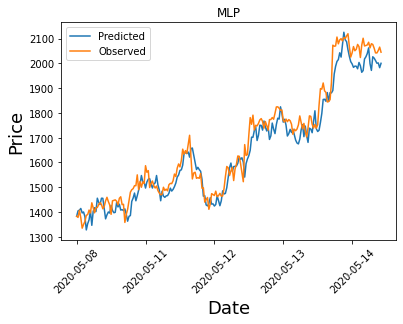

In [ ]:
company_stock.Mlp_model()

Multilayer perceptron (MLP)
R2 SCORE
0.9509369364988102
MSLE
0.0009222046805280311
Training time: 0.38799595832824707s
Testing time: 0.39345765113830566s


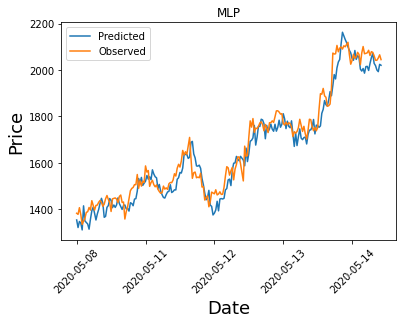

In [ ]:
company_stock.Mlp_model_optimized()

Recurrent neural network (RNN)
Epoch 1/10
1945/1945 [==============================] - 14s 7ms/step - loss: 0.0054
Epoch 2/10
1945/1945 [==============================] - 13s 7ms/step - loss: 0.0011
Epoch 3/10
1945/1945 [==============================] - 13s 7ms/step - loss: 6.3564e-04
Epoch 4/10
1945/1945 [==============================] - 14s 7ms/step - loss: 4.8402e-04
Epoch 5/10
1945/1945 [==============================] - 14s 7ms/step - loss: 3.6977e-04
Epoch 6/10
1945/1945 [==============================] - 14s 7ms/step - loss: 3.2620e-04
Epoch 7/10
1945/1945 [==============================] - 13s 7ms/step - loss: 2.9856e-04
Epoch 8/10
1945/1945 [==============================] - 13s 7ms/step - loss: 2.6841e-04
Epoch 9/10
1945/1945 [==============================] - 13s 7ms/step - loss: 2.9239e-04
Epoch 10/10
7/7 [==============================] - 0s 5ms/step
r2 SCORE
0.11748659839879705
MSLE
0.014514655493467612
Training time: 136.11304187774658s
Testing time: 136.65537118911743

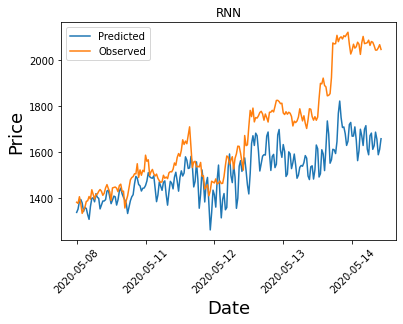

In [ ]:
company_stock.rnn_model()

Recurrent neural network (RNN)
Epoch 1/10
1945/1945 [==============================] - 14s 7ms/step - loss: 0.0452
Epoch 2/10
1945/1945 [==============================] - 13s 7ms/step - loss: 0.0055
Epoch 3/10
1945/1945 [==============================] - 13s 7ms/step - loss: 0.0035
Epoch 4/10
1945/1945 [==============================] - 13s 7ms/step - loss: 0.0025
Epoch 5/10
1945/1945 [==============================] - 13s 7ms/step - loss: 0.0021
Epoch 6/10
1945/1945 [==============================] - 13s 7ms/step - loss: 0.0020
Epoch 7/10
1945/1945 [==============================] - 13s 7ms/step - loss: 0.0020
Epoch 8/10
1945/1945 [==============================] - 14s 7ms/step - loss: 0.0022
Epoch 9/10
1945/1945 [==============================] - 13s 7ms/step - loss: 0.0021
Epoch 10/10
7/7 [==============================] - 0s 5ms/step
r2 SCORE
0.5168776640510069
MSLE
0.00849171860433536
Training time: 133.50051546096802s
Testing time: 133.7721004486084s


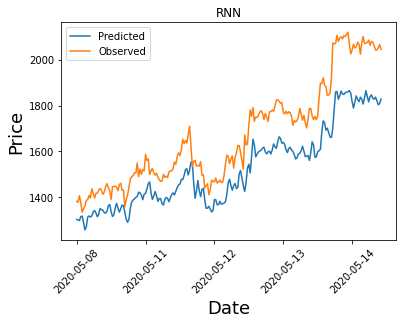

In [ ]:
company_stock.rnn_model_optimized()

Long Short-Term Memory (LSTM)
7/7 [==============================] - 1s 38ms/step
R2 SCORE
0.7703666544860096
MSLE
0.003967479204560952
Training time: 70.40339207649231s
Testing time: 71.5696611404419s


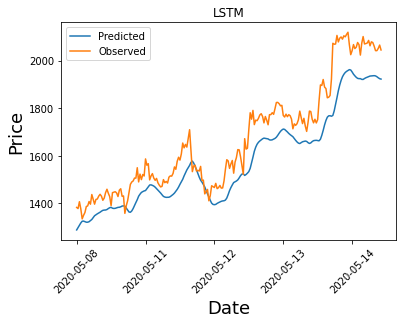

In [ ]:
company_stock.LSTM_model()